In [47]:
import pandas as pd
import numpy as np
import json
import re
import os
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

In [48]:
DATA_DIR = os.path.join('..', '..', 'data')
INPUT_FILE = os.path.join(DATA_DIR, 'avito_details.json')
LOG_FILE = os.path.join(DATA_DIR, 'cleaning_log.txt')
MODEL_FILE = os.path.join(DATA_DIR, 'best_model.pkl')

def log_action(message):
    timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    full_message = f"[{timestamp}] {message}"
    print(full_message)
    
    if not os.path.exists(DATA_DIR):
        os.makedirs(DATA_DIR)
        
    with open(LOG_FILE, "a", encoding="utf-8") as f:
        f.write(full_message + "\n")

if os.path.exists(LOG_FILE):
    open(LOG_FILE, 'w').close()

log_action("Запуск анализа данных")

[2025-12-15 15:15:18] Запуск анализа данных


In [49]:
if os.path.exists(INPUT_FILE):
    with open(INPUT_FILE, 'r', encoding='utf-8') as f:
        raw_data = json.load(f)
    log_action(f"Файл загружен. Найдено записей: {len(raw_data)}")
else:
    log_action(f"Ошибка загрузки")
    raw_data = []

df = pd.json_normalize(raw_data)

initial_len = len(df)
df = df.dropna(how='all')
log_action(f"Датафрейм создан. Размер: {df.shape}")

[2025-12-15 15:15:18] Файл загружен. Найдено записей: 3234
[2025-12-15 15:15:18] Датафрейм создан. Размер: (3234, 44)


In [50]:
if 'url' in df.columns:
    dupes = df.duplicated(subset=['url']).sum()
    df = df.drop_duplicates(subset=['url'])
    log_action(f"Удалено дубликатов по URL: {dupes}")

def clean_price_value(val): # преобразуем цену в float
    if pd.isna(val): return None
    clean = re.sub(r'\D', '', str(val))
    return float(clean) if clean else None

def clean_area_value(val): # преобразуем площадь в float
    if pd.isna(val): return None
    match = re.search(r'(\d+[.,]?\d*)', str(val))
    if match:
        return float(match.group(1).replace(',', '.'))
    return None

def clean_rooms_value(val): # Преобразуем текст числа комнат в int
    """Преобразует '1', '2', 'Студия' в число"""
    if pd.isna(val): return None
    s = str(val).lower()
    if 'студия' in s: return 0.8
    match = re.search(r'(\d+)', s)
    return int(match.group(1)) if match else None

def clean_district_value(val): # чуть чистим район
    if pd.isna(val): return "Unknown"
    return str(val).replace('р-н ', '').strip()

df['clean_price'] = df['price'].apply(clean_price_value)

if 'about_apartment.Общая площадь' in df.columns:
    df['clean_area'] = df['about_apartment.Общая площадь'].apply(clean_area_value)
else:
    df['clean_area'] = None

if 'about_apartment.Количество комнат' in df.columns:
    df['clean_rooms'] = df['about_apartment.Количество комнат'].apply(clean_rooms_value)
else:
    df['clean_rooms'] = None

if 'location.district' in df.columns:
    df['clean_district'] = df['location.district'].apply(clean_district_value)
else:
    df['clean_district'] = "Unknown"

df_clean = df.dropna(subset=['clean_price', 'clean_area', 'clean_rooms'])
log_action(f"После очистки типов данных осталось: {len(df_clean)} строк")

def remove_outliers_zscore(dframe, col_name, threshold=3):
    z_scores = np.abs(stats.zscore(dframe[col_name]))
    return dframe[z_scores < threshold]

df_clean = remove_outliers_zscore(df_clean, 'clean_price')
df_clean = remove_outliers_zscore(df_clean, 'clean_area')

log_action(f"После удаления выбросов (Z-score) осталось: {len(df_clean)} строк")

[2025-12-15 15:15:18] Удалено дубликатов по URL: 0
[2025-12-15 15:15:18] После очистки типов данных осталось: 3229 строк
[2025-12-15 15:15:18] После удаления выбросов (Z-score) осталось: 3137 строк


In [51]:
def print_full_stats(series, name):
    if series.empty:
        print(f"Нет данных для {name}")
        return

    mean_val = series.mean()
    median_val = series.median()
    try:
        mode_val = series.mode()[0]
    except:
        mode_val = np.nan
        
    min_val = series.min()
    max_val = series.max()
    std_dev = series.std()
    variance = series.var()
    
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    
    skew = series.skew() 
    kurt = series.kurtosis() 
    
    mad = (series - mean_val).abs().mean()

    print(f"Количество: {len(series)}")
    print(f"Среднее:    {mean_val:.2f}")
    print(f"Медиана:    {median_val:.2f}")
    print(f"Мода:       {mode_val}")
    print(f"Мин: {min_val} | Макс: {max_val}")
    print(f"Стд. откл: {std_dev:.2f} | Дисперсия: {variance:.2f}")
    print(f"IQR: {iqr:.2f} (Q1={q1:.2f}, Q3={q3:.2f})")
    print(f"Среднее абс. отклонение (MAD): {mad:.2f}")
    print(f"Асимметрия: {skew:.2f} | Эксцесс: {kurt:.2f}")

print_full_stats(df_clean['clean_price'], "Цена (руб)")
print_full_stats(df_clean['clean_area'], "Площадь (м²)")

corr = df_clean['clean_price'].corr(df_clean['clean_area'], method='pearson')
print(f"\nКорреляция Пирсона (Цена vs Площадь): {corr:.4f}")

Количество: 3137
Среднее:    3057.44
Медиана:    2900.00
Мода:       3000.0
Мин: 1000.0 | Макс: 7194.0
Стд. откл: 1043.85 | Дисперсия: 1089631.14
IQR: 1140.00 (Q1=2360.00, Q3=3500.00)
Среднее абс. отклонение (MAD): 795.10
Асимметрия: 1.18 | Эксцесс: 1.42
Количество: 3137
Среднее:    43.90
Медиана:    42.00
Мода:       45.0
Мин: 12.2 | Макс: 84.0
Стд. откл: 11.90 | Дисперсия: 141.66
IQR: 14.00 (Q1=36.00, Q3=50.00)
Среднее абс. отклонение (MAD): 9.03
Асимметрия: 0.70 | Эксцесс: 0.53

Корреляция Пирсона (Цена vs Площадь): 0.4556


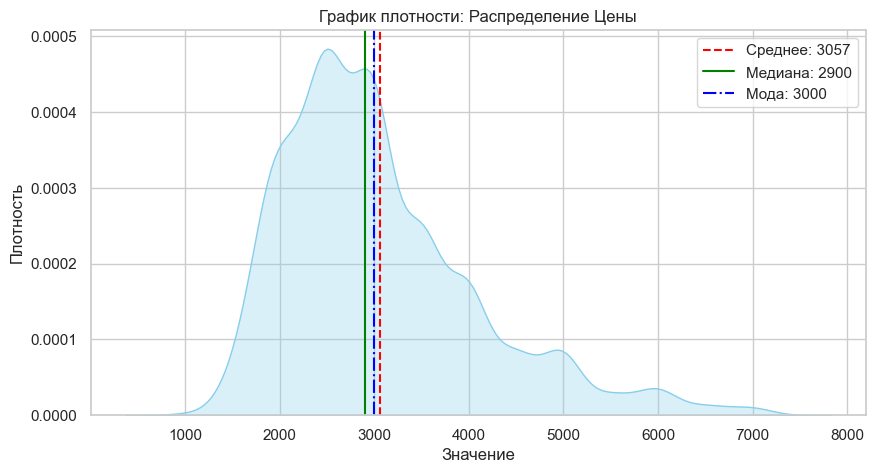

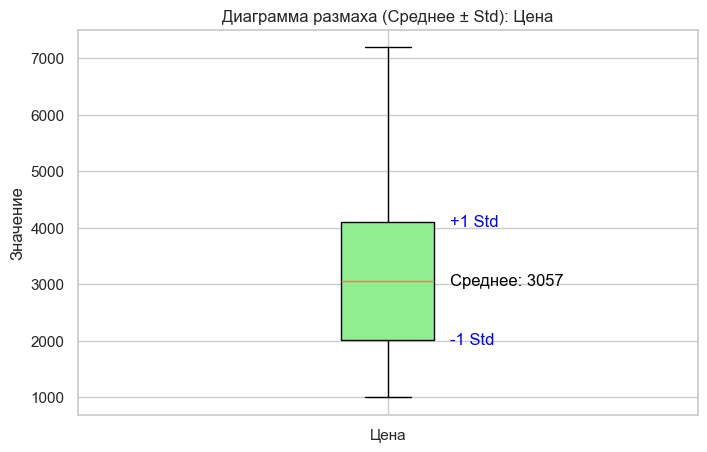

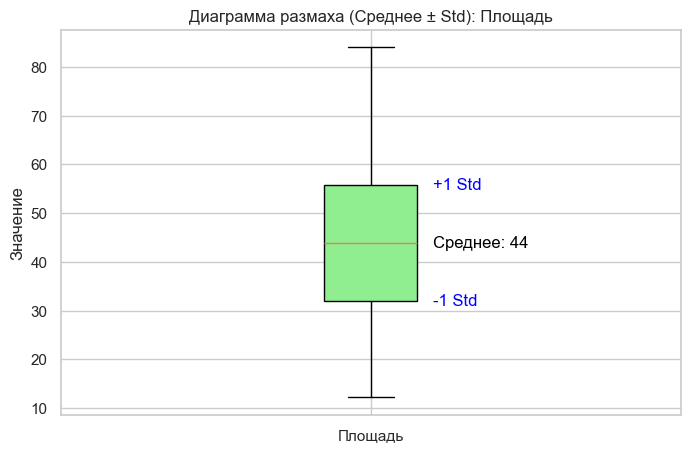

In [52]:
def plot_density(series, title):
    plt.figure(figsize=(10, 5))
    sns.kdeplot(series, fill=True, color='skyblue', alpha=0.3)
    
    mean_val = series.mean()
    median_val = series.median()
    try:
        mode_val = series.mode()[0]
    except:
        mode_val = np.nan
    
    plt.axvline(mean_val, color='red', linestyle='--', label=f'Среднее: {mean_val:.0f}')
    plt.axvline(median_val, color='green', linestyle='-', label=f'Медиана: {median_val:.0f}')
    if not np.isnan(mode_val):
        plt.axvline(mode_val, color='blue', linestyle='-.', label=f'Мода: {mode_val:.0f}')
    
    plt.title(f'График плотности: {title}')
    plt.xlabel('Значение')
    plt.ylabel('Плотность')
    plt.legend()
    plt.show()

plot_density(df_clean['clean_price'], "Распределение Цены")

def plot_mean_std_boxplot(series, title):
    mean_val = series.mean()
    std_val = series.std()
    min_val = series.min()
    max_val = series.max()
    
    stats_dict = [{
        'label': title,
        'whislo': min_val,     
        'q1': mean_val - std_val,  
        'med': mean_val,          
        'q3': mean_val + std_val,
        'whishi': max_val,       
        'fliers': [] 
    }]
    
    fig, ax = plt.subplots(figsize=(8, 5))
    
    ax.bxp(stats_dict, showfliers=False, patch_artist=True, 
           boxprops=dict(facecolor="lightgreen"))
    
    ax.set_title(f'Диаграмма размаха (Среднее ± Std): {title}')
    ax.set_ylabel('Значение')
    ax.grid(True)
    
    ax.text(1.1, mean_val, f'Среднее: {mean_val:.0f}', va='center', color='black')
    ax.text(1.1, mean_val + std_val, f'+1 Std', va='center', color='blue')
    ax.text(1.1, mean_val - std_val, f'-1 Std', va='center', color='blue')
    
    plt.show()

plot_mean_std_boxplot(df_clean['clean_price'], "Цена")
plot_mean_std_boxplot(df_clean['clean_area'], "Площадь")

[2025-12-15 15:15:18] Приступаем к ML
Корреляция (Комнаты vs Цена): 0.3728

Результаты обучения моделей

Модель: Linear Regression
  MAE: 722.40 руб
  RMSE: 965.24 руб
  R²: 0.1455
--------------------
Модель: Random Forest
  MAE: 772.43 руб
  RMSE: 1045.18 руб
  R²: -0.0019
--------------------
Модель: XGBoost
  MAE: 756.19 руб
  RMSE: 1016.97 руб
  R²: 0.0515
--------------------


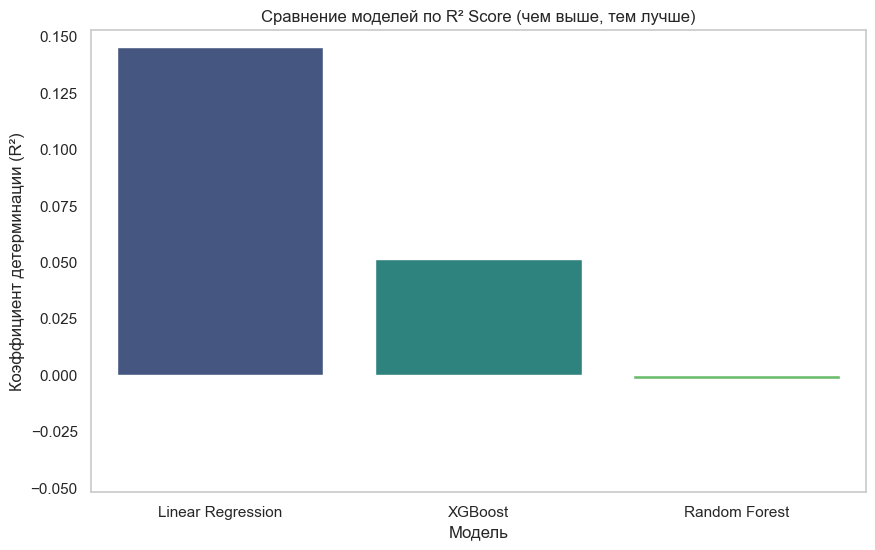


Итоговая таблица:
              Модель   MAE (руб)   RMSE (руб)  R2 Score
0  Linear Regression  722.396257   965.235688  0.145535
2            XGBoost  756.185658  1016.966195  0.051493
1      Random Forest  772.430079  1045.184517 -0.001875

Random Forest дал вот такие признаки:
                                             Признак  Важность
0                                         clean_area  0.794768
1                                        clean_rooms  0.090096
4                          clean_district_Московский  0.043197
3                       clean_district_Ленинградский  0.041707
5                         clean_district_Центральный  0.028597
2  clean_district_Калининградская обл., Калинингр...  0.001635


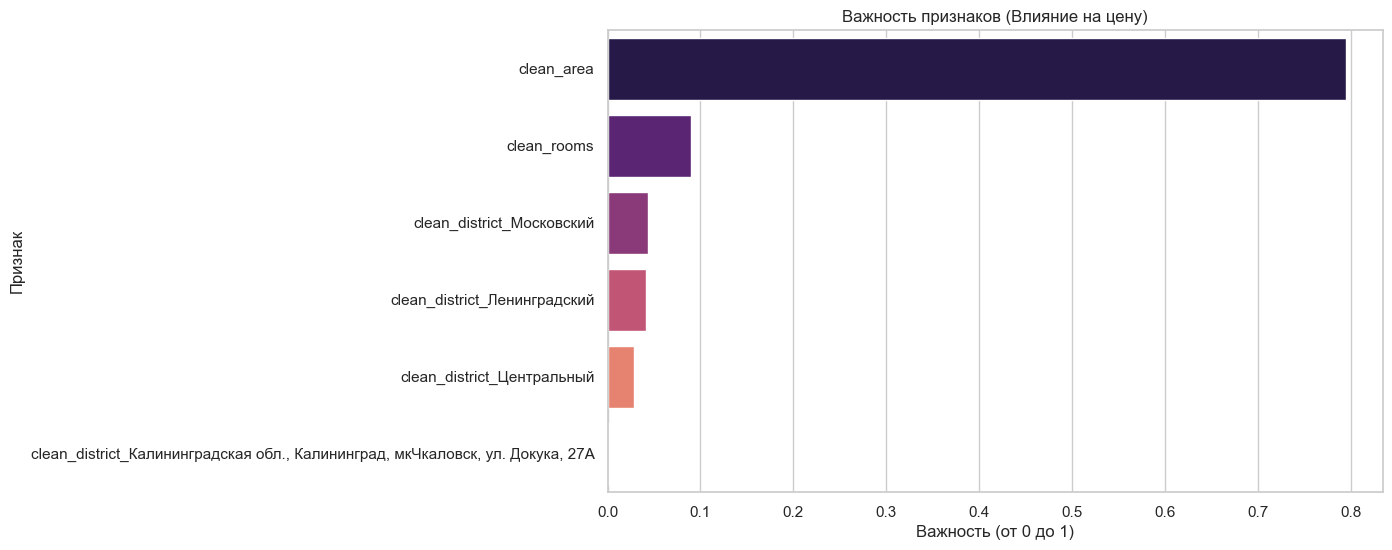

In [53]:
log_action("Приступаем к ML")

data_ml = df_clean[['clean_price', 'clean_area', 'clean_rooms', 'clean_district']].copy()

data_ml = pd.get_dummies(data_ml, columns=['clean_district'], drop_first=True)

import re
data_ml.columns = [re.sub(r'[<\[\]]', "", col) for col in data_ml.columns]

X = data_ml.drop('clean_price', axis=1)
y = data_ml['clean_price']

rooms_corr = data_ml['clean_rooms'].corr(data_ml['clean_price'])
print(f"Корреляция (Комнаты vs Цена): {rooms_corr:.4f}\n")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    "XGBoost": XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42, n_jobs=-1)
}

results = []
best_score = -np.inf
best_model = None
best_model_name = ""
rf_model_instance = None 

print("Результаты обучения моделей\n")

for name, model in models.items():
    model.fit(X_train, y_train)
    
    if name == "Random Forest":
        rf_model_instance = model
    
    y_pred = model.predict(X_test)
    
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    results.append({
        "Модель": name,
        "MAE (руб)": mae,
        "RMSE (руб)": rmse,
        "R2 Score": r2
    })
    
    print(f"Модель: {name}")
    print(f"  MAE: {mae:.2f} руб")
    print(f"  RMSE: {rmse:.2f} руб")
    print(f"  R²: {r2:.4f}")
    print("-" * 20)
    
    if r2 > best_score:
        best_score = r2
        best_model = model
        best_model_name = name

res_df = pd.DataFrame(results)
res_df = res_df.sort_values(by="R2 Score", ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x="Модель", y="R2 Score", data=res_df, hue="Модель", palette="viridis", legend=False)
plt.title("Сравнение моделей по R² Score (чем выше, тем лучше)")
plt.ylim(bottom=min(0, res_df['R2 Score'].min() - 0.05))
plt.ylabel("Коэффициент детерминации (R²)")
plt.grid(axis='y')
plt.show()

print("\nИтоговая таблица:")
print(res_df)

if rf_model_instance:
    importances = rf_model_instance.feature_importances_
            
    imp_df = pd.DataFrame({'Признак': X.columns, 'Важность': importances})
    imp_df = imp_df.sort_values(by='Важность', ascending=False)
    
    print("\nRandom Forest дал вот такие признаки:")
    print(imp_df.head(10))
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Важность', y='Признак', data=imp_df.head(10), hue='Признак', palette='magma', legend=False)
    plt.title("Важность признаков (Влияние на цену)")
    plt.xlabel("Важность (от 0 до 1)")
    plt.show()